In [1]:
!python --version

Python 3.7.12


In [2]:
!pip list | grep tensor

tensorboard                   2.8.0
tensorboard-data-server       0.6.1
tensorboard-plugin-wit        1.8.1
tensorflow                    2.8.0
tensorflow-datasets           4.0.1
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.24.0
tensorflow-metadata           1.7.0
tensorflow-probability        0.16.0


In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Basic numerical computing

In [4]:
import numpy as np

# Initialize a numpy ndarray with 3 rows, 2 columns
X = np.zeros((3, 2))
X

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [5]:
# By default, ndarrays are float64
X.shape, X.dtype

((3, 2), dtype('float64'))

In [6]:
# We can set values of a whole row
X[0, :] = 1
X

array([[1., 1.],
       [0., 0.],
       [0., 0.]])

In [7]:
# We can set values of a whole column
X[:, 0] = 2
X

array([[2., 1.],
       [2., 0.],
       [2., 0.]])

In [8]:
X = np.array([
  [1, 2],
  [3, 4],
  [5, 6]
])
X

array([[1, 2],
       [3, 4],
       [5, 6]])

In [9]:
x = np.array([10, 20])
print(x)
print(X.shape, x.shape)

# We can add ndarrays of different dimensions
X + x

[10 20]
(3, 2) (2,)


array([[11, 22],
       [13, 24],
       [15, 26]])

In [10]:
X.shape, x.shape

((3, 2), (2,))

In [11]:
# Element-wise multiplication

X * x

array([[ 10,  40],
       [ 30,  80],
       [ 50, 120]])

In [12]:
# Matrix multiplication
# http://matrixmultiplication.xyz/

x = np.array([[10, 20],]).T
result = X @ x  # alternatively, np.dot(X, x)
result

array([[ 50],
       [110],
       [170]])

Indexing

In [13]:
X = np.random.rand(3, 2)
X

array([[0.1678832 , 0.59410614],
       [0.48369587, 0.10525163],
       [0.02955513, 0.87250192]])

In [14]:
X > 0.5

array([[False,  True],
       [False, False],
       [False,  True]])

In [15]:
X[X > 0.5] = 1
X

array([[0.1678832 , 1.        ],
       [0.48369587, 0.10525163],
       [0.02955513, 1.        ]])

Basic plotting

In [16]:
import matplotlib.pyplot as plt
plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

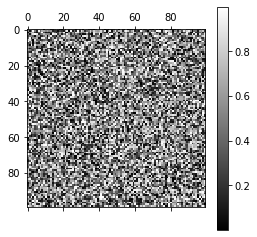

In [17]:
X = np.random.rand(100, 100)
plt.matshow(X)
plt.colorbar()

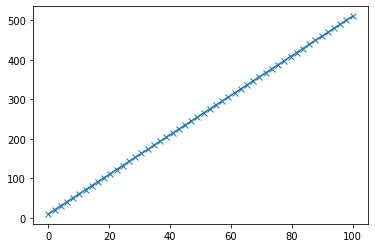

In [18]:
x = np.linspace(0, 100)
y = x * 5 + 10
# y = x * w + b

plt.plot(x, y, 'x-')

Basic regression with a linear model

x: (50, 1), weights: (1, 1), bias: (1,), y: (50, 1)


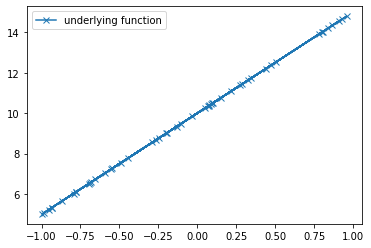

In [19]:
# x is 1-dimensional

n = 50

d = 1
x = np.random.uniform(-1, 1, (n, d))

# y = 5x + 10
weights_true = np.array([[5],])
bias_true = np.array([10])

y_true = x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plt.plot(x, y_true, marker='x', label='underlying function')
plt.legend()

Basic prediction function: Linear

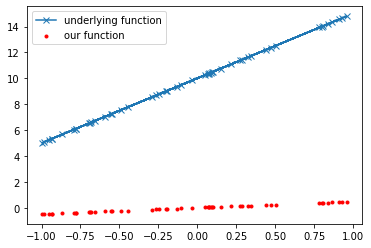

In [21]:
# Let's initialize our predictions

class Linear:
  def __init__(self, input_dim, num_hidden=1):
    # The initialization is important to properly deal with different
    # input sizes (otherwise gradients quickly go to 0).
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    return x @ self.weights + self.bias

linear = Linear(d)
y_pred = linear(x)
plt.plot(x, y_true, marker='x', label='underlying function')
plt.scatter(x, y_pred, color='r', marker='.', label='our function')
plt.legend()

Basic loss function: MSE

In [22]:
# How wrong are these initial predictions, exactly?
# It's up to us, and our definition is called the loss function.
# Let's use Mean Squared Error (MSE) as our loss function.

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_true - y_pred) ** 2).mean()
  
loss = MSE()
print(f'Our initial loss is {loss(y_pred, y_true)}')

Our initial loss is 99.43248089422805


Add back propagation

In [23]:
# Let's use gradient descent to learn the weights and bias that minimizes the loss function.
# For this, we need the gradient of the loss function and the gradients of the linear function.

class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient


class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [24]:
# Take one step forward and one step backward to make sure nothing breaks, and that the loss decreases.
loss = MSE()
linear = Linear(d)
y_pred = linear(x)
print(loss(y_pred, y_true))
loss_gradient = loss.backward()
linear.backward(loss_gradient)
linear.update(0.1)
y_pred = linear(x)
print(loss(y_pred, y_true))

99.82981146094451
66.44058311946935


Train using gradient descent!

Epoch 0, loss 98.66792280780673
Epoch 5, loss 13.901485196383213
Epoch 10, loss 3.209604537478242
Epoch 15, loss 1.1921547915249795
Epoch 20, loss 0.5420745695408852
Epoch 25, loss 0.2600603603938654
Epoch 30, loss 0.12628115857872022
Epoch 35, loss 0.06148078257465156


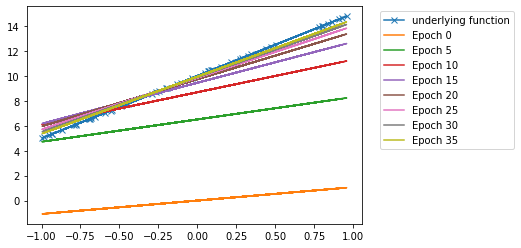

In [25]:
plt.plot(x, y_true, marker='x', label='underlying function')

loss = MSE()
linear = Linear(d)

num_epochs = 40
lr = 0.1

for epoch in range(num_epochs):
  y_pred = linear(x)
  loss_value = loss(y_pred, y_true)

  if epoch % 5 == 0:
    print(f'Epoch {epoch}, loss {loss_value}')
    plt.plot(x, y_pred.squeeze(), label=f'Epoch {epoch}')

  gradient_from_loss = loss.backward()
  linear.backward(gradient_from_loss)
  linear.update(lr)

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left");

2-dimensional inputs work, too

(100, 2) (2, 1) (1,)
x: (100, 2), weights: (2, 1), bias: (1,), y: (100, 1)


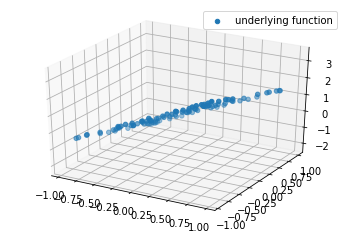

In [26]:
# What about 2-dimensional x?

n = 100
d = 2
x = np.random.uniform(-1, 1, (n, d))

# y = w * x + b
# y = w_0 * x_0 + w_1 * x_1 + b
# y = w@x + b

weights_true = np.array([[2, -1], ]).T
bias_true = np.array([0.5])
print(x.shape, weights_true.shape, bias_true.shape)

y_true = x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

plot_3d(x, y_true)

0.3162035580698829


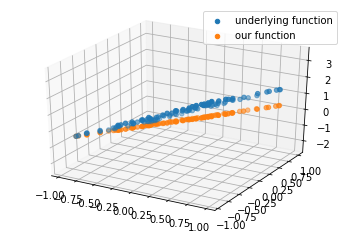

In [27]:
loss = MSE()
linear = Linear(2)
y_pred = linear(x)
print(loss(y_pred, y_true))
fig = plot_3d(x, y_true, y_pred)

Epoch 0, loss 0.3162035580698829
Epoch 1, loss 0.21850891685815466
Epoch 2, loss 0.1541403866436646
Epoch 3, loss 0.11128860943557262
Epoch 4, loss 0.08238517772087624
Epoch 5, loss 0.06257271485744734
Epoch 6, loss 0.048727715508764806
Epoch 7, loss 0.038836331405382764
Epoch 8, loss 0.0315955303107664
Epoch 9, loss 0.02615817798003695
Epoch 10, loss 0.021970038744495133
Epoch 11, loss 0.01866548977733297
Epoch 12, loss 0.016000746554056346
Epoch 13, loss 0.01381106009521096
Epoch 14, loss 0.011983239245933626
Epoch 15, loss 0.010437975180161272
Epoch 16, loss 0.009118440011739901
Epoch 17, loss 0.007982905121891102
Epoch 18, loss 0.006999938226122072
Epoch 19, loss 0.006145257714355885


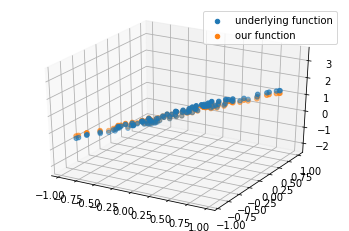

In [28]:
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=20)
plot_3d(x, y_true, linear(x))

Basic regression with a Multi-layer Perceptron


x: (200, 2), weights: (2, 1), bias: (1,), y: (200, 1)


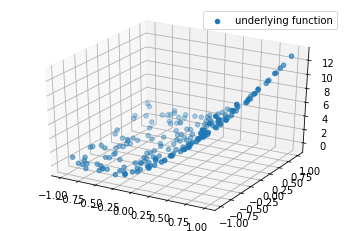

In [29]:
# Make non-linear data

n = 200
d = 2
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[5, 1],]).T
bias_true = np.array([1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

plot_3d(x, y_true)

Epoch 0, loss 17.42411270018036
Epoch 1, loss 13.661663966675318
Epoch 2, loss 11.043547683156197
Epoch 3, loss 9.18412575206139
Epoch 4, loss 7.833436170531656
Epoch 5, loss 6.828665825670137
Epoch 6, loss 6.063086650332798
Epoch 7, loss 5.466156375886144
Epoch 8, loss 4.990758904029738
Epoch 9, loss 4.605012032877494
Epoch 10, loss 4.286998441125504
Epoch 11, loss 4.021368891154352
Epoch 12, loss 3.797145574549377
Epoch 13, loss 3.606295702979422
Epoch 14, loss 3.4428002340114587
Epoch 15, loss 3.3020415687838978
Epoch 16, loss 3.1803973251821844
Epoch 17, loss 3.074967755388445
Epoch 18, loss 2.983390269015191
Epoch 19, loss 2.903711100054878
Epoch 20, loss 2.8342947770564253
Epoch 21, loss 2.7737588680838248
Epoch 22, loss 2.7209258471493034
Epoch 23, loss 2.6747867439412385
Epoch 24, loss 2.634473054472952
Epoch 25, loss 2.5992345653222175
Epoch 26, loss 2.5684215077955277
Epoch 27, loss 2.541469957452024
Epoch 28, loss 2.5178897229907258
Epoch 29, loss 2.497254186819211
Epoch 30,

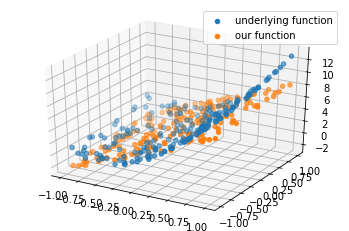

In [30]:
# We can train just fine, but the final loss will remain high, as our linear function is incapable
# of representing the data.

loss = MSE()
linear = Linear(d)
fit(x, y_true, model=linear, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, linear(x))

Add non-linearity: ReLU

In [31]:
# In order to learn non-linear functions, we need non-linearities in our model.

class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = np.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      # import pdb; pdb.set_trace()  # By the way, this is how you can debug
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient


relu = Relu()
input_ = np.expand_dims(np.array([1, 0.5, 0, -0.5, -1]), -1)
print(relu(input_))
print(relu.backward(input_))

[[1. ]
 [0.5]
 [0. ]
 [0. ]
 [0. ]]
[[ 1. ]
 [ 0.5]
 [ 0. ]
 [-0. ]
 [-0. ]]


Train our new non-linear model

17.117728750170137


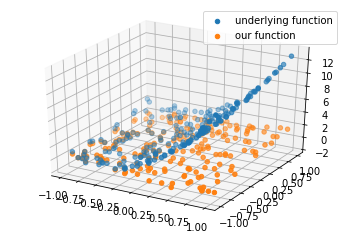

In [32]:
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 1)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    # print('Model backward', linear2_gradient.shape, relu_gradient.shape, linear1_gradient.shape)
    # import pdb; pdb.set_trace()
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
loss_gradient = loss.backward()
print(loss_value)
model.backward(loss_gradient)
plot_3d(x, y_true, y_pred)

In [33]:
# Test just one forward and backward step
loss = MSE()
model = Model(d, 10)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.1)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)

19.58997414272839
6.597094425416822


Epoch 0, loss 6.597094425416822
Epoch 1, loss 4.505870196953216
Epoch 2, loss 3.4073327858017204
Epoch 3, loss 2.6696611566772916
Epoch 4, loss 2.189877695618999
Epoch 5, loss 1.8414328051821536
Epoch 6, loss 1.588539688920324
Epoch 7, loss 1.3835459531680612
Epoch 8, loss 1.2134668539372329
Epoch 9, loss 1.0673001503615642
Epoch 10, loss 0.9411672965579708
Epoch 11, loss 0.8284296660242358
Epoch 12, loss 0.7319037223444618
Epoch 13, loss 0.6494794093095407
Epoch 14, loss 0.579477663199725
Epoch 15, loss 0.5197734471347769
Epoch 16, loss 0.46697065843653496
Epoch 17, loss 0.4221398045992561
Epoch 18, loss 0.38421451842054594
Epoch 19, loss 0.35213113109954164
Epoch 20, loss 0.32459915663580163
Epoch 21, loss 0.30150338228006457
Epoch 22, loss 0.28189312667046473
Epoch 23, loss 0.2647573565808981
Epoch 24, loss 0.25044601012820805
Epoch 25, loss 0.23822059352970493
Epoch 26, loss 0.22766873021859277
Epoch 27, loss 0.21876241979813454
Epoch 28, loss 0.21111375796103068
Epoch 29, loss 0.2

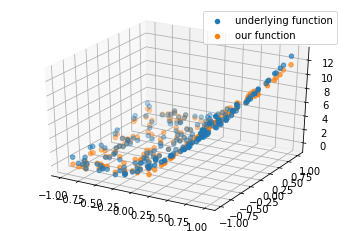

In [34]:
fit(x, y_true, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x))

Same thing, in PyTorch

In [35]:
import torch
import torch.nn as nn


class TorchModel(nn.Module):
  def __init__(self, input_dim, num_hidden):
    super().__init__()
    self.linear1 = nn.Linear(input_dim, num_hidden)
    self.relu = nn.ReLU()
    self.linear2 = nn.Linear(num_hidden, 1)
  
  def forward(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2


loss = nn.MSELoss()
model = TorchModel(d, 10)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(19.2221, grad_fn=<MseLossBackward0>)


In [36]:
# Test just one forward and backward step
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

optimizer.zero_grad()
y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)
loss_gradient = loss_value.backward()
optimizer.step()

y_pred_tensor = model(x_tensor)
loss_value = loss(y_pred_tensor, y_true_tensor)
print(loss_value)

tensor(19.2221, grad_fn=<MseLossBackward0>)
tensor(13.5895, grad_fn=<MseLossBackward0>)


tensor(13.5895, grad_fn=<MseLossBackward0>)
tensor(10.2546, grad_fn=<MseLossBackward0>)
tensor(7.4398, grad_fn=<MseLossBackward0>)
tensor(5.3008, grad_fn=<MseLossBackward0>)
tensor(3.8506, grad_fn=<MseLossBackward0>)
tensor(2.8280, grad_fn=<MseLossBackward0>)
tensor(2.0780, grad_fn=<MseLossBackward0>)
tensor(1.5553, grad_fn=<MseLossBackward0>)
tensor(1.2145, grad_fn=<MseLossBackward0>)
tensor(0.9942, grad_fn=<MseLossBackward0>)
tensor(0.8435, grad_fn=<MseLossBackward0>)
tensor(0.7379, grad_fn=<MseLossBackward0>)
tensor(0.6619, grad_fn=<MseLossBackward0>)
tensor(0.6032, grad_fn=<MseLossBackward0>)
tensor(0.5564, grad_fn=<MseLossBackward0>)
tensor(0.5190, grad_fn=<MseLossBackward0>)
tensor(0.4885, grad_fn=<MseLossBackward0>)
tensor(0.4633, grad_fn=<MseLossBackward0>)
tensor(0.4418, grad_fn=<MseLossBackward0>)
tensor(0.4211, grad_fn=<MseLossBackward0>)
tensor(0.4030, grad_fn=<MseLossBackward0>)
tensor(0.3866, grad_fn=<MseLossBackward0>)
tensor(0.3721, grad_fn=<MseLossBackward0>)
tensor(0.

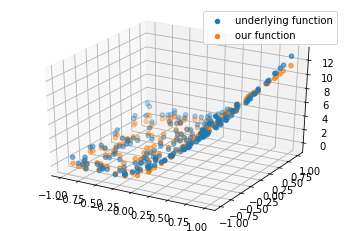

In [37]:
# Now we run the training loop

def torch_fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred_tensor = model(x_tensor)
    loss_value = loss(y_pred_tensor, y_true_tensor)
    print(loss_value)
    loss_value.backward()
    optimizer.step()

torch_fit(x_tensor, y_true_tensor, model=model, loss=loss, lr=0.1, num_epochs=40)
plot_3d(x, y_true, model(x_tensor).detach())

Same thing, in Tensorflow/Keras

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                                 
 regression (Dense)          (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 12.0900
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 3.9505
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 1.0992
Epoch 4/10
7/7 [==============================] - 0s 2ms/step - loss: 0.9159
Epoch 5/10
7/7 

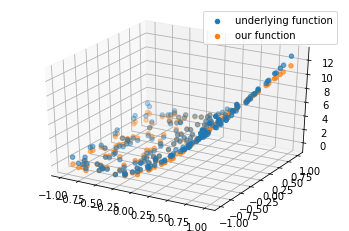

In [38]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

inputs = keras.Input(shape=(2,))
l1 = layers.Dense(10, activation='relu', name='dense_1')(inputs)
outputs = layers.Dense(1, name='regression')(l1)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))

model.fit(x, y_true, epochs=10)

y_pred = model.predict(x)

plot_3d(x, y_true, model(x))